In [1]:
%matplotlib ipympl

import numpy as np
from matplotlib import pyplot as plt
import hj_reachability as hj
import hj_reachability.shapes as shp
import pyspect as ps
import plotly.graph_objects as go
import skimage.io as sio

from ipywidgets import interact, IntSlider
from functools import partial


In [2]:
BACKGROUND_PATH = 'Eskilstuna-Intersection.png'

reach_dynamics = hj.systems.Bicycle5D(min_steer=-np.pi, 
                                      max_steer=+np.pi,
                                      min_accel=-0.3,
                                      max_accel=+0.3).with_mode('reach')
avoid_dynamics = hj.systems.Bicycle5D(min_steer=-np.pi, 
                                      max_steer=+np.pi,
                                      min_accel=-0.3,
                                      max_accel=+0.3).with_mode('avoid')

min_bounds = np.array([0.0, 0.0, -np.pi, -np.pi/5, +0.1])
max_bounds = np.array([8.0, 6.0, +np.pi, +np.pi/5, +1.1])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (61, 46, 31, 7, 11),
                                                               periodic_dims=2)

X, Y, A, D, V = range(grid.ndim)

print('dx =', grid.spacings[0], 
      'dy =', grid.spacings[1],
      'da =', grid.spacings[2],
      'dv =', grid.spacings[4])

dx = 0.13333334 dy = 0.13333334 da = 0.20268339 dv = 0.1


In [3]:
def plot_set(ax, vf, **kwargs):
    vf = shp.project_onto(vf, 0, 1) # project non-shared states to the shared states
    vf = np.where(vf <= 0, 0.5, np.nan)            
    vf = vf.T # imshow flips axis
    return [ax.imshow(vf, vmin=0, vmax=1, origin='lower', **kwargs)]

def plot_map(*pairs, **kwargs):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9*4/3, 9))
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    background = plt.imread(BACKGROUND_PATH)
    ax.imshow(background, extent=extent)
    for cmap, vf in pairs:
        kw = dict(alpha=0.9, cmap=plt.get_cmap(cmap), extent=extent)
        kw.update(kwargs)
        plot_set(ax, vf, **kw)
    fig.tight_layout()
    return fig

def implies(a, b):
    return shp.union(shp.complement(a), b)

def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

def plot_arrow(ax: plt.Axes, pt, a, **kwargs):
    arrow_length = 0.25
    x1, y1 = pt
    x2 = arrow_length*np.cos(a) * 4/3
    y2 = arrow_length*np.sin(a)
    xbound = lambda x: max(grid.coordinate_vectors[0][0],
                           min(grid.coordinate_vectors[0][-1],
                               x))
    ybound = lambda y: max(grid.coordinate_vectors[1][0],
                           min(grid.coordinate_vectors[1][-1],
                               y))
    x1, x2 = map(xbound, [x1, x2])
    y1, y2 = map(ybound, [y1, y2])
    return [ax.arrow(x1, y1, x2, y2, **kwargs)]

def plot_set(ax: plt.Axes, vf, **kwargs):
    vf = np.where(vf <= 0, 0.5, np.nan)            
    vf = vf.T # imshow flips axis
    return [ax.imshow(vf, vmin=0, vmax=1, origin='lower', **kwargs)]

def interact_scenario(times, *pairs):
    fig, ax = plt.figure(), plt.gca()
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis('off')
    ax.invert_yaxis()
    interaction = partial(interact, 
                        #   yaw_idx=IntSlider(0, min=0, max=grid.shape[2]-1),
                          vel_idx=IntSlider(0, min=0, max=grid.shape[4]-1),
                          time_idx=IntSlider(0, min=0, max=len(times)-1))
    def render_frame(# yaw_idx, 
                     vel_idx, 
                     time_idx):
        # print('yaw:', grid.coordinate_vectors[2][yaw_idx] * 180/np.pi)
        print('vel:', grid.coordinate_vectors[4][vel_idx])
        print('t:', times[time_idx])
        ax.clear()
        background = plt.imread(BACKGROUND_PATH)
        ax.imshow(background, extent=extent)
        for cmap, vf in pairs:
            cmap = plt.get_cmap(cmap)
            if not shp.is_invariant(grid, times, vf):
                vf = vf[time_idx, :, :, :, :, vel_idx]
            vf = shp.project_onto(vf, 0, 1)
            plot_set(ax, vf, alpha=0.9, cmap=cmap, extent=extent)
            # ix, iy = np.unravel_index(vf.argmin(), vf.shape)
            # x = grid.coordinate_vectors[0][ix]
            # y = grid.coordinate_vectors[1][iy]
            # a = grid.coordinate_vectors[2][yaw_idx]
            # if vf[ix, iy] <= 0:
            #     plot_arrow(ax, (x, y), a, color=cmap(0.75))
        fig.tight_layout()
        return fig
    return interaction, render_frame

def interact_tubes(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[times[0]:times[-1]:complex(0, len(times)),
                            min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=times[0]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            vf = shp.project_onto(values, 0, 1, 2)
            if time_idx is not None and time_idx < len(times)-1:
                vf[time_idx+1:] = 1

            data += [
                go.Isosurface(
                    x=meshgrid[1].flatten(),
                    y=meshgrid[2].flatten(),
                    z=meshgrid[0].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='t [s]'),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes_vel(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1]),
                            min_bounds[4]:max_bounds[4]:complex(0, grid.shape[4])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=min_bounds[4]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            axes = 1, 2, 5
            vf = (shp.project_onto(values, *axes) if time_idx is None else
                  shp.project_onto(values, 0, *axes)[time_idx])

            data += [
                go.Isosurface(
                    x=meshgrid[0].flatten(),
                    y=meshgrid[1].flatten(),
                    z=meshgrid[2].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='v [m/s]'),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes_yaw(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1]),
                            min_bounds[2]:max_bounds[2]:complex(0, grid.shape[2])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=min_bounds[2]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            axes = 1, 2, 3
            vf = (shp.project_onto(values, *axes) if time_idx is None else
                  shp.project_onto(values, 0, *axes)[time_idx])

            data += [
                go.Isosurface(
                    x=meshgrid[0].flatten(),
                    y=meshgrid[1].flatten(),
                    z=meshgrid[2].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    opacity=0.8,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='Yaw [rad]'),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def sphere_to_cartesian(r, theta, phi):
    theta *= np.pi/180
    phi *= np.pi/180
    return dict(x=r*np.sin(theta)*np.cos(phi),
                y=r*np.sin(theta)*np.sin(phi),
                z=r*np.cos(theta))

EYE_W   = sphere_to_cartesian(2.2, 45, -90 - 90)
EYE_WSW = sphere_to_cartesian(2.2, 70, -90 - 70)
EYE_SW  = sphere_to_cartesian(2.5, 60, -90 - 45)
EYE_SSW = sphere_to_cartesian(2.2, 70, -90 - 20)
EYE_S   = sphere_to_cartesian(2.5, 45, -90 + 0)
EYE_SSE = sphere_to_cartesian(2.2, 70, -90 + 20)
EYE_SE  = sphere_to_cartesian(2.5, 60, -90 + 45)
EYE_ESE = sphere_to_cartesian(2.2, 70, -90 + 70)
EYE_E   = sphere_to_cartesian(2.2, 45, -90 + 90)

## Safe Intersection

### Environment

In [31]:
SX, SY = grid.domain.hi[0] - grid.domain.lo[0], grid.domain.hi[1] - grid.domain.lo[1]

C30 = 0.6
C50 = 1.0

print('Creating intersection')
intersection = shp.intersection(shp.hyperplane(grid, normal=[-1, 1], offset=[SX * 4.60/8, SY * 2.67/6]),
                                shp.hyperplane(grid, normal=[1, 1],  offset=[SX * 6.40/8, SY * 2.67/6]),
                                shp.rectangle(grid, 
                                              target_min=[SX * 4.20/8, SY * 1.20/6], 
                                              target_max=[SX * 6.87/8, SY * 3.04/6]))
print('Creating kyrkogatan_right')
kyrkogatan_right = shp.union(intersection,
                             shp.rectangle(grid, 
                                           target_min=[SX * 0.00/8, SY * 1.20/6, -np.pi/5],
                                           target_max=[SX * 5.33/8, SY * 1.84/6, +np.pi/5]),
                             shp.rectangle(grid, 
                                           target_min=[SX * 6.00/8, SY * 1.20/6, -np.pi/5],
                                           target_max=[SX * 8.00/8, SY * 1.73/6, +np.pi/5]))
kyrkogatan_right = shp.intersection(kyrkogatan_right,
                                    implies(shp.upper_half_space(grid, X, SX * 3.00/8), 
                                            shp.rectangle(grid, axes=[V], target_min=[0.3], target_max=[C30])),
                                    implies(shp.lower_half_space(grid, X, SX * 3.01/8), 
                                            shp.rectangle(grid, axes=[V], target_min=[0.4], target_max=[C50])))
print('Creating kyrkogatan_left')
kyrkogatan_left = shp.union(intersection,
                            shp.rectangle(grid, 
                                          target_min=[SX * 0.00/8, SY * 1.85/6, +np.pi - np.pi/5], 
                                          target_max=[SX * 5.33/8, SY * 2.37/6, -np.pi + np.pi/5]),
                            shp.rectangle(grid, 
                                          target_min=[SX * 6.00/8, SY * 1.70/6, +np.pi - np.pi/5], 
                                          target_max=[SX * 8.00/8, SY * 2.24/6, -np.pi + np.pi/5]))
kyrkogatan_left = shp.intersection(kyrkogatan_left,
                                   implies(shp.upper_half_space(grid, X, SX * 3.00/8), 
                                           shp.rectangle(grid, axes=[V], target_min=[0.3], target_max=[C30])),
                                   implies(shp.lower_half_space(grid, X, SX * 3.01/8), 
                                           shp.rectangle(grid, axes=[V], target_min=[0.4], target_max=[C50])))
print('Creating nygatan_up')
nygatan_up = shp.union(intersection,
                       shp.rectangle(grid, 
                                     target_min=[SX * 5.60/8, SY * 2.27/6, +np.pi/2 - np.pi/5], 
                                     target_max=[SX * 6.14/8, SY * 6.00/6, +np.pi/2 + np.pi/5]),
                       shp.rectangle(grid, 
                                     target_min=[SX * 5.33/8, SY * 0.00/6, +np.pi/2 - np.pi/5], 
                                     target_max=[SX * 5.74/8, SY * 1.60/6, +np.pi/2 + np.pi/5]))
nygatan_up = shp.intersection(nygatan_up,
                              implies(shp.upper_half_space(grid, Y, SY * 4.00/6), 
                                      shp.rectangle(grid, axes=[V], target_min=[0.4], target_max=[C50])),
                              implies(shp.lower_half_space(grid, Y, SY * 4.01/6), 
                                      shp.rectangle(grid, axes=[V], target_min=[0.3], target_max=[C30])))
print('Creating nygatan_down')
nygatan_down = shp.union(intersection,
                         shp.rectangle(grid, 
                                       target_min=[SX * 4.94/8, SY * 2.26/6, -np.pi/2 - np.pi/5],
                                       target_max=[SX * 5.53/8, SY * 6.00/6, -np.pi/2 + np.pi/5]),
                         shp.rectangle(grid, 
                                       target_min=[SX * 5.07/8, SY * 0.00/6, -np.pi/2 - np.pi/5],
                                       target_max=[SX * 5.47/8, SY * 1.60/6, -np.pi/2 + np.pi/5]))
print('Creating parking_spots')
parking_spot_entry_1 = shp.rectangle(grid, 
                                     target_min=[SX * 2.00/8, SY * 5.33/6], 
                                     target_max=[SX * 2.53/8, SY * 5.73/6])
parking_spot_1 = shp.rectangle(grid, 
                               target_min=[SX * 2.13/8, SY * 5.54/6, +np.pi/2 - np.pi/5], 
                               target_max=[SX * 2.40/8, SY * 6.00/6, +np.pi/2 + np.pi/5])
parking_spot_entry_2 = shp.rectangle(grid, 
                                     target_min=[SX * 3.02/8, SY * 4.67/6], 
                                     target_max=[SX * 3.61/8, SY * 5.07/6])
parking_spot_2 = shp.rectangle(grid, 
                               target_min=[SX * 3.15/8, SY * 4.33/6, -np.pi/2 - np.pi/5], 
                               target_max=[SX * 3.47/8, SY * 4.80/6, -np.pi/2 + np.pi/5])
print('Creating parking_lot')
parking_lot = shp.union(shp.rectangle(grid, target_min=[SX * 1.46/8, SY * 2.73/6], target_max=[SX * 2.00/8, SY * 6.00/6]),  # left side
                        shp.rectangle(grid, target_min=[SX * 1.46/8, SY * 3.27/6], target_max=[SX * 4.40/8, SY * 3.74/6]),  # bottom
                        shp.rectangle(grid, target_min=[SX * 4.07/8, SY * 3.33/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # right side
                        shp.rectangle(grid, target_min=[SX * 1.47/8, SY * 4.87/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # top
                        shp.rectangle(grid, target_min=[SX * 1.47/8, SY * 2.13/6], target_max=[SX * 1.93/8, SY * 3.00/6]))  # entry
# parking_lot = shp.union(parking_lot,
#                         parking_spot_entry_1, parking_spot_1,
#                         parking_spot_entry_2, parking_spot_2)
parking_lot = shp.intersection(parking_lot,
                               shp.lower_half_space(grid, V, C30))
print('Creating entry_zone and exit_zone')
# exit_zone = shp.rectangle(grid, target_min=[SX * 5.67/8, SY * 4.50/6], target_max=[SX * 6.13/8, SY * 4.95/6])
exit_zone = shp.rectangle(grid, 
                          target_min=[SX * 5.67/8, SY * 5.47/6], 
                          target_max=[SX * 6.13/8, SY * 5.93/6])
entry_zone = shp.rectangle(grid, 
                           target_min=[SX * 1.50/8, SY * 1.87/6], 
                           target_max=[SX * 1.95/8, SY * 2.33/6])
parking_start = shp.rectangle(grid,
                              target_min=[SX * 2.30/8, SY * 1.87/6],
                              target_max=[SX * 2.75/8, SY * 2.33/6])
print('Done!')

Creating intersection
Creating kyrkogatan_right
Creating kyrkogatan_left
Creating nygatan_up
Creating nygatan_down
Creating parking_spots
Creating parking_lot
Creating entry_zone and exit_zone
Done!


In [5]:
parking_lot = shp.union(parking_lot, 
                        shp.rectangle(grid, 
                                      target_min=[SX * 1.47/8, SY * 1.30/6], 
                                      target_max=[SX * 1.93/8, SY * 3.00/6]), # extended entry
                        shp.rectangle(grid,
                                      target_min=[SX * 1.47/8, SY * 1.85/6, +np.pi - np.pi/3], 
                                      target_max=[SX * 2.20/8, SY * 2.40/6, -np.pi + np.pi/5]), # box left direction
                        shp.rectangle(grid, 
                                      target_min=[SX * 1.20/8, SY * 1.20/6, -np.pi/5],
                                      target_max=[SX * 1.93/8, SY * 1.90/6, +np.pi/3]), # box right direction
)

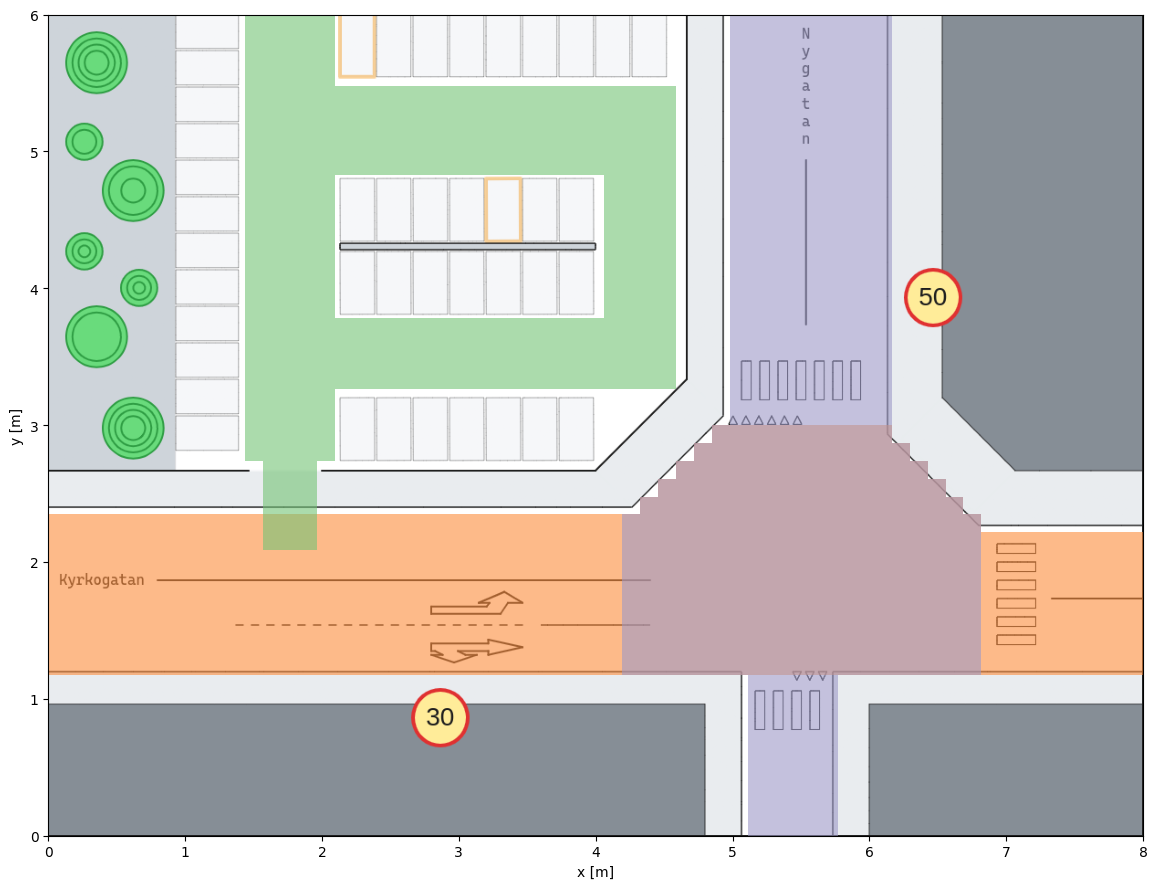

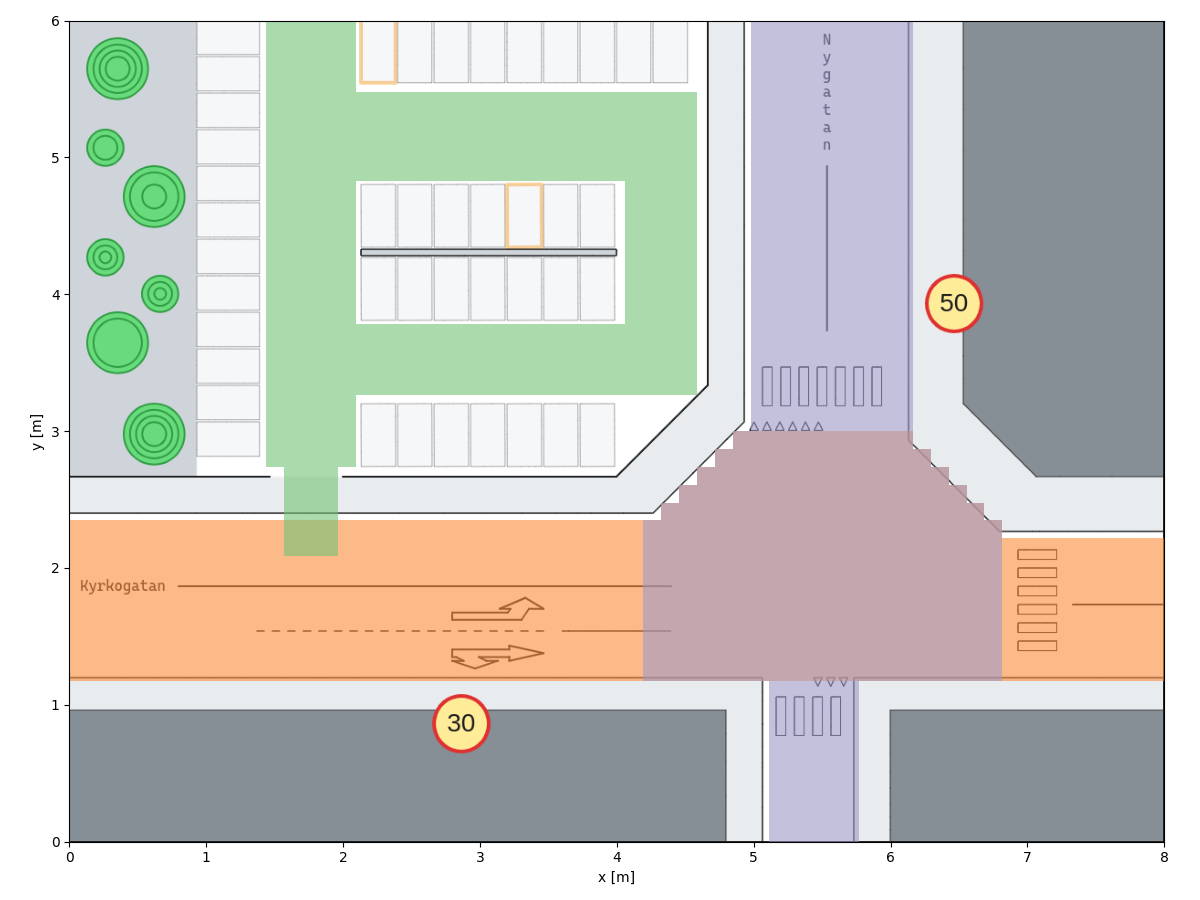

In [32]:
plot_map(
    # ('Grays', shp.project_onto(parking_lot, 0, 1)),
    ('Oranges', shp.project_onto(shp.union(kyrkogatan_left, kyrkogatan_right), 0, 1)),
    ('Purples', shp.project_onto(shp.union(nygatan_down, nygatan_up), 0, 1)),
    ('Greens', shp.project_onto(parking_lot, 0, 1)),
    alpha=0.6,
)

### Implementation

In [7]:
from time import time
import numpy.lib.stride_tricks as st

AVOID_MARGIN = 0.1

solver_settings = hj.SolverSettings.with_accuracy("low")

def frs(times, target, constraints=None, *, mode='avoid'):
    times = np.asarray(times)
    dynamics = reach_dynamics if mode == 'reach' else avoid_dynamics
    values = hj.solve(solver_settings, dynamics, grid,
                      times, target, constraints)
    values = np.asarray(values)
    return values

def brs(times, target, constraints=None, *, mode='reach'):
    dynamics = reach_dynamics if mode == 'reach' else avoid_dynamics
    times = -np.asarray(times)
    if not  shp.is_invariant(grid, times, target):
        target = np.flip(target, axis=0)
    if not shp.is_invariant(grid, times, constraints):
        constraints = np.flip(constraints, axis=0)
    values = hj.solve(solver_settings, dynamics, grid,
                      times, target, constraints)
    values = np.asarray(values)
    values = np.flip(values, axis=0)
    return values

def find_windows(mask, N=1, M=None):
    """Find the indices of windows where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    assert N <= len(mask)
    window_view = st.sliding_window_view(mask, window_shape=N)
    ix, = np.where(N == np.sum(window_view, axis=1))
    if M is not None:
        assert M <= len(mask)
        assert N < M
        window_view = st.sliding_window_view(mask, window_shape=M)
        jx = ix[ix + M <= len(mask)]
        iix, = np.where(np.sum(window_view[jx], axis=1) < M)
        ix = ix[iix]
    return ix

def earliest_window(mask, N=1, M=None):
    """Find the first window where at least N but less than M consequtive elements are true."""
    mask = np.asarray(mask)
    windows = find_windows(mask, N, M)
    if len(windows) == 0:
        return np.array([], int)
    i = windows[0] # Earliest window
    mask = mask[i:] if M is None else mask[i:i+M]
    for j, n in enumerate(mask.cumsum()[N-1:]):
        if n != j + N:
            break
    return np.arange(i, i+n)

def run(*passes, **kwargs):
    ALL_PASSES = ['pass1', 'pass2', 'pass3', 'pass4']
    passes = passes or ALL_PASSES
    if 'all' in passes:
        passes = ALL_PASSES
    passes = [name for name in ALL_PASSES if name in passes]

    returns = list(passes)

    for name in passes:
        assert name in ALL_PASSES, f'Invalid pass: {name}'
        i = ALL_PASSES.index(name)
        
        if i > 0 and ALL_PASSES[i-1] not in passes + list(kwargs):
            passes += [ALL_PASSES[i-1]]
    passes = [name for name in ALL_PASSES if name in passes]

    msg = 'Running the following passes: '
    msg += ', '.join(passes) + '\n'
    msg += '-' * (len(msg)-1)
    print(msg)

    def to_shared(values, **kwargs):
        return shp.project_onto(values, 0, 1, 2, **kwargs)
    
    def when_overlapping(a, b):
        return np.where(shp.project_onto(shp.intersection(a, b), 0) <= 0)[0]
    
    def pass1():
        print('\n', 'Pass 1: Initial BRS')
        times = kwargs['times']
        rules = kwargs['rules']
        end = kwargs['end']

        target = shp.make_tube(times, end)
        constraints = rules

        start_time = time()
        result = brs(times, target, constraints)
        stop_time = time()

        print(f'Time To Compute: {stop_time - start_time:.02f}')
        return result
    
    def pass2():
        print('\n', 'Pass 2: Avoidance')
        times = kwargs['times']
        avoid = kwargs['avoid']
        end = kwargs['end']

        if not avoid:
            result = kwargs['pass1']
        else:
            result = kwargs['pass1'].copy()

            avoid_target = shp.union(
                *map(lambda target: to_shared(target, keepdims=True), avoid),
            ) - AVOID_MARGIN # increase avoid set with heuristic margin

            interact_window = when_overlapping(result, avoid_target)
            if 0 < interact_window.size:
                i, j = interact_window[0], interact_window[-1] + 1

                # Recompute solution until after last interaction
                constraints = shp.setminus(result, avoid_target)[:j+1]
                target = result[:j+1]    # last step is target to reach pass1
                target[:-1] = end       # all other steps are recomputed to end
                
                start_time = time()
                result[:j+1] = brs(times[:j+1], target, constraints)
                stop_time = time()
            
                print(f'Time To Compute: {stop_time - start_time:.02f}')
                print(f'First Interaction: {times[i]:.01f}')
                print(f'Last Interaction: {times[j-1]:.01f}')
        return result

    def pass3():
        print('\n', 'Pass 3: Planning, Departure')
        result = kwargs['pass2'].copy()
        times = kwargs['times']
        start = kwargs['start']

        depart_target = shp.intersection(result, start)
        depart_window = earliest_window(shp.project_onto(depart_target, 0) <= 0, 5)
        assert depart_window.size > 0, 'No window to depart'
        i = depart_window[0] # Earliest departure
        j = depart_window[min(11, len(depart_window)-1)] # Depart within 2 seconds of earliest departure
        depart_target[j:] = 1

        start_time = time()
        result[i:] = frs(times[i:], depart_target[i:], result[i:])
        result[:i] = 1 # Remove all values before departure
        stop_time = time()

        print(f'Time To Compute: {stop_time - start_time:.02f}')
        print(f'Earliest Departure: {times[i]:.01f}')
        print(f'Latest Departure: {times[j-1]:.01f}')
        return result

    def pass4():
        print('\n', 'Pass 4: Planning, Arrival')
        result = kwargs['pass3'].copy()
        times = kwargs['times']
        start = kwargs['start']
        end = kwargs['end']

        depart_target = shp.intersection(result, start)
        depart_window = earliest_window(shp.project_onto(depart_target, 0) <= 0, 5)
        assert depart_window.size > 0, 'No window to depart'
        i = depart_window[0] # Earliest departure
        j = depart_window[min(11, len(depart_window)-1)] # Depart within 2 seconds of earliest departure
        depart_target[j:] = 1

        arrival_target = shp.intersection(result, end)
        arrival_window = earliest_window(shp.project_onto(arrival_target, 0) <= 0, N=5)
        assert arrival_window.size > 0, 'No window to arrive'
        m = arrival_window[0] # Earliest arrival
        n = arrival_window[min(11, len(depart_window)-1)] # Arrive within 2 seconds of earliest arrival
        arrival_target[n:] = 1

        start_time = time()
        result[i:n] = brs(times[i:n], arrival_target[i:n], result[i:n])
        result[n:] = 1 # Remove all values after arrival
        stop_time = time()

        print(f'Time To Compute: {stop_time - start_time:.02f}')
        print(f'Earliest Arrival: {times[m]:.01f}')
        print(f'Latest Arrival: {times[n-1]:.01f}')
        return result

    if 'pass1' in passes:
        kwargs['pass1'] = pass1()
    if 'pass2' in passes:
        kwargs['pass2'] = pass2()
        if 'pass1' not in returns: del kwargs['pass1']
    if 'pass3' in passes:
        kwargs['pass3'] = pass3()
        if 'pass2' not in returns: del kwargs['pass2']
    if 'pass4' in passes:
        kwargs['pass4'] = pass4()
        if 'pass3' not in returns: del kwargs['pass3']
    
    return [kwargs[name] for name in returns]

def run_many(*objectives, **kwargs):
    results = []
    for o in objectives:
        results += run('pass4', **o, **kwargs, avoid=results)
        print('\n')
    return results

In [11]:
if False:
    (v1_pass1,) = run('pass1', # 'pass3',  # 'pass4',
        rules=shp.union(kyrkogatan_right, nygatan_up),
        avoid=[],
        start=entry_zone,
        end=exit_zone,
        times=new_timeline(20),
    )
else:
    (v2_pass1,) = run('pass1',
        rules=shp.union(kyrkogatan_right, kyrkogatan_left, parking_lot),
        avoid=[],
        start=parking_start,
        end=shp.union(parking_spot_1, parking_spot_2),
        times=new_timeline(20),
    )

Running the following passes: pass1
-----------------------------------

 Pass 1: Initial BRS


100%|##########| 20.0000/20.0 [00:28<00:00,  1.43s/sim_s]

Time To Compute: 28.63


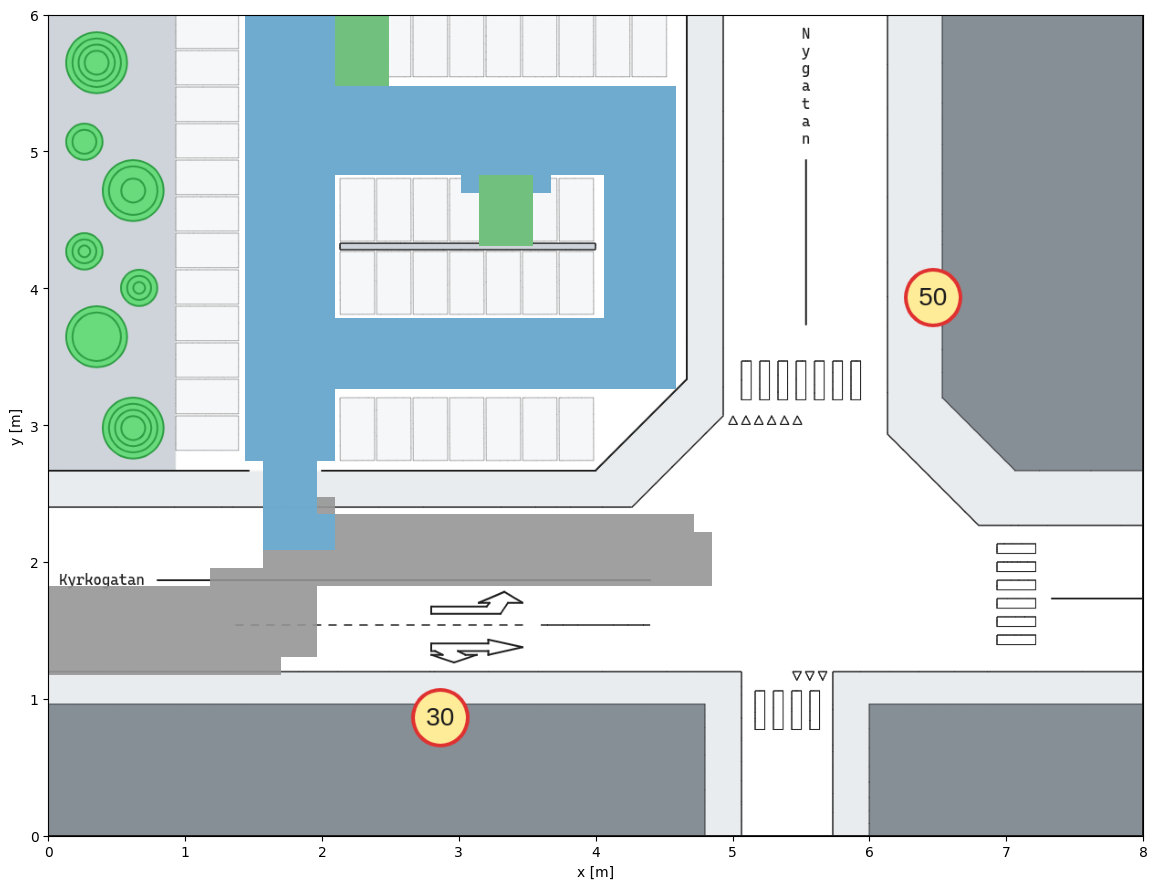

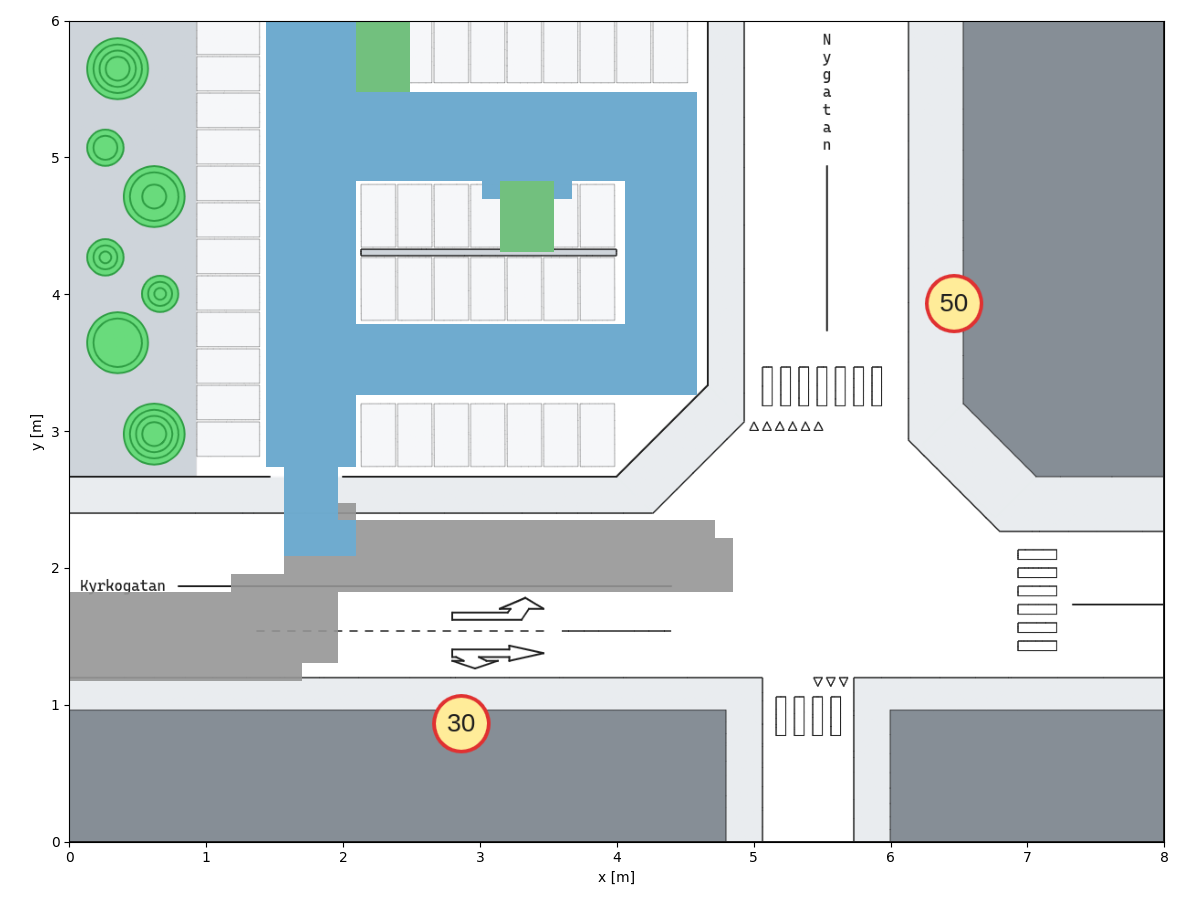

In [25]:
plot_map(
    # ('Grays', shp.project_onto(shp.union(
    #         shp.union(kyrkogatan_left, parking_lot),
    #         shp.union(parking_spot_entry_1, parking_spot_1),
    #         shp.union(parking_spot_entry_2, parking_spot_2),
    #     ), 0, 1)
    # ),

    ## Parking ##
    ('Greys', shp.project_onto(v1_pass1, 1, 2)),
    ('Blues', shp.project_onto(v2_pass1, 1, 2)),
    # ('Greens', shp.project_onto(parking_start, 0, 1)),
    ('Greens', shp.project_onto(shp.union(parking_spot_1, parking_spot_2), 0, 1)),
    
    # ## Environment ##
    # ('Oranges', shp.project_onto(shp.union(kyrkogatan_left, kyrkogatan_right), 0, 1)),
    # ('Purples', shp.project_onto(shp.union(nygatan_down, nygatan_up), 0, 1)),
    # ('Greens', shp.project_onto(parking_lot, 0, 1)),
    
    # alpha=0.7,
)

In [ ]:
I, F = interact_tubes(
    new_timeline(10),
    # ('Greys', shp.make_tube(new_timeline(10), kyrkogatan_left)),
    ('Blues',   v1_pass1),
    # ('Greens',  v1_pass3),
    # ('Reds',    v1_pass4),
    eye=EYE_SSW,
)
if False:
    r = I(F)
else:
    r = F().show(config=dict(toImageButtonOptions=dict(height=720, width=720, scale=6)))

r

In [ ]:
vf = v1_pass1
vf = shp.project_onto(vf, 0, 5)

idx = np.where(vf <= 0)

itov = lambda i: grid.coordinate_vectors[4][i]
xs = new_timeline(8)
miny = np.array([itov(min(idx[1][idx[0] == i])) for i in range(len(xs)) if len(idx[1][idx[0] == i])])
maxy = np.array([itov(max(idx[1][idx[0] == i])) for i in range(len(xs)) if len(idx[1][idx[0] == i])])
xs = np.array([xs[i]for i in range(len(xs)) if len(idx[1][idx[0] == i])])
print(xs)
plt.figure()
plt.fill_between(xs, miny, maxy)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Velocity Profile')

## PySpect

In [4]:
class Set(ps.Set):

    vf: np.ndarray
    grid: hj.Grid
    timeline: np.ndarray
    dynamics: hj.Dynamics

    solver_settings = hj.SolverSettings.with_accuracy("low")
    
    def __init__(self, dynamics, grid, timeline, vf, **kwargs):
        super().__init__(**kwargs)

        self.dynamics = dynamics
        self.timeline = timeline
        self.grid = grid
        self.vf = vf

    def copy(self):
        return Set(self.dynamics, 
                   self.grid, 
                   self.timeline.copy(), 
                   self.vf.copy(), 
                   approx=self.approx)
    
    @classmethod
    def empty(self):
        return np.ones(self.grid.shape)
    
    def is_empty(self):
        return np.all(0 < self.vf)
    
    def membership(self, point):
        idx = self.grid.nearest_index(point)
        return self.vf[idx] <= 0
    
    def complement(self):
        s = super().complement()
        s.vf = np.asarray(-s.vf)
        return s
    
    def union(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().union(other)
        s.vf = np.asarray(np.minimum(self.vf, other.vf))
        return s
    
    def intersect(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().intersect(other)
        s.vf = np.asarray(np.maximum(self.vf, other.vf))
        return s
    
    def reach(self, constraints=None):
        s = super().reach(constraints)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      self.vf,
                      constraints if constraints is None else constraints.vf)
        s.vf = np.asarray(vf)
        return s

    def rci(self):
        s = super().rci()
        s._make_tube()
        target = np.ones_like(s.vf)
        target[-1, ...] = s.vf[-1, ...]
        constraint = s.vf
        vf = hj.solver(self.solver_settings,
                       self.dynamics,
                       self.grid,
                       self.timeline,
                       target,
                       constraint)
        s.vf = np.asarray(np.flip(vf, axis=0))
        return s

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))


In [5]:
def env():
    SX, SY = grid.domain.hi[0] - grid.domain.lo[0], grid.domain.hi[1] - grid.domain.lo[1]

    timeline = new_timeline(20)

    print('Creating speed limits')
    limit_30 =  Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, V, 0.6))
    limit_50 =  Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, V, 1.0))

    print('Creating road geometries')
    intersection_geometry = Set(reach_dynamics, grid, timeline,
                                shp.intersection(shp.hyperplane(grid, normal=[-1, 1], offset=[SX * 4.60/8, SY * 2.67/6]),
                                                shp.hyperplane(grid, normal=[1, 1],  offset=[SX * 6.40/8, SY * 2.67/6]),
                                                shp.rectangle(grid, 
                                                            target_min=[SX * 4.20/8, SY * 1.20/6], 
                                                            target_max=[SX * 6.87/8, SY * 3.04/6])))
    kyrkogatan_left_geometry  = Set(reach_dynamics, grid, timeline,
                                    shp.union(shp.rectangle(grid, 
                                                            target_min=[SX * 0.00/8, SY * 1.85/6, +np.pi - np.pi/5], 
                                                            target_max=[SX * 5.33/8, SY * 2.37/6, -np.pi + np.pi/5]),
                                            shp.rectangle(grid, 
                                                            target_min=[SX * 6.00/8, SY * 1.70/6, +np.pi - np.pi/5], 
                                                            target_max=[SX * 8.00/8, SY * 2.24/6, -np.pi + np.pi/5]))).union(intersection_geometry)
    kyrkogatan_right_geometry = Set(reach_dynamics, grid, timeline,
                                    shp.union(shp.rectangle(grid, 
                                                            target_min=[SX * 0.00/8, SY * 1.20/6, -np.pi/5],
                                                            target_max=[SX * 5.33/8, SY * 1.84/6, +np.pi/5]),
                                            shp.rectangle(grid, 
                                                            target_min=[SX * 6.00/8, SY * 1.20/6, -np.pi/5],
                                                            target_max=[SX * 8.00/8, SY * 1.73/6, +np.pi/5]))).union(intersection_geometry)
    nygatan_down_geometry = Set(reach_dynamics, grid, timeline,
                                shp.union(shp.rectangle(grid, 
                                                        target_min=[SX * 4.94/8, SY * 2.26/6, -np.pi/2 - np.pi/5],
                                                        target_max=[SX * 5.53/8, SY * 6.00/6, -np.pi/2 + np.pi/5]),
                                        shp.rectangle(grid, 
                                                        target_min=[SX * 5.07/8, SY * 0.00/6, -np.pi/2 - np.pi/5],
                                                        target_max=[SX * 5.47/8, SY * 1.60/6, -np.pi/2 + np.pi/5]))).union(intersection_geometry)
    nygatan_up_geometry   = Set(reach_dynamics, grid, timeline,
                                shp.union(shp.rectangle(grid, 
                                                    target_min=[SX * 5.60/8, SY * 2.27/6, +np.pi/2 - np.pi/5], 
                                                    target_max=[SX * 6.14/8, SY * 6.00/6, +np.pi/2 + np.pi/5]),
                                        shp.rectangle(grid, 
                                                    target_min=[SX * 5.33/8, SY * 0.00/6, +np.pi/2 - np.pi/5], 
                                                    target_max=[SX * 5.74/8, SY * 1.60/6, +np.pi/2 + np.pi/5]))).union(intersection_geometry)

    print('Creating streets')
    kyrkogatan_vel  = ps.And(ps.Implies(Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, X, SX * 3.01/8)), limit_50),
                            ps.Implies(Set(reach_dynamics, grid, timeline, shp.upper_half_space(grid, X, SX * 3.00/8)), limit_30))
    nygatan_vel     = ps.And(ps.Implies(Set(reach_dynamics, grid, timeline, shp.lower_half_space(grid, Y, SY * 4.01/6)), limit_30),
                            ps.Implies(Set(reach_dynamics, grid, timeline, shp.upper_half_space(grid, Y, SY * 4.00/6)), limit_50))
    kyrkogatan_left     = ps.And(kyrkogatan_left_geometry, kyrkogatan_vel)
    kyrkogatan_right    = ps.And(kyrkogatan_right_geometry, kyrkogatan_vel)
    nygatan_down        = ps.And(nygatan_down_geometry, nygatan_vel)
    nygatan_up          = ps.And(nygatan_up_geometry, nygatan_vel) 
    kyrkogatan  = ps.Or(kyrkogatan_left, kyrkogatan_right)
    nygatan     = ps.Or(nygatan_down, nygatan_up)

    print('Creating entry/exit zones')
    exit_zone     = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 5.67/8, SY * 5.47/6], 
                                    target_max=[SX * 6.13/8, SY * 5.93/6]))
    entry_zone    = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 1.50/8, SY * 1.87/6], 
                                    target_max=[SX * 1.95/8, SY * 2.33/6]))
    parking_start = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid,
                                    target_min=[SX * 2.30/8, SY * 1.87/6],
                                    target_max=[SX * 2.75/8, SY * 2.33/6]))

    print('Creating parking lot')
    parking_spot_1 = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 2.13/8, SY * 5.54/6, +np.pi/2 - np.pi/5], 
                                    target_max=[SX * 2.40/8, SY * 6.00/6, +np.pi/2 + np.pi/5]))
    parking_spot_2 = Set(reach_dynamics, grid, timeline,
                        shp.rectangle(grid, 
                                    target_min=[SX * 3.15/8, SY * 4.33/6, -np.pi/2 - np.pi/5], 
                                    target_max=[SX * 3.47/8, SY * 4.80/6, -np.pi/2 + np.pi/5]))
    parking_spot_entry_1 = Set(reach_dynamics, grid, timeline,
                            shp.rectangle(grid, 
                                            target_min=[SX * 2.00/8, SY * 5.33/6], 
                                            target_max=[SX * 2.53/8, SY * 5.73/6]))
    parking_spot_entry_2 = Set(reach_dynamics, grid, timeline,
                            shp.rectangle(grid, 
                                            target_min=[SX * 3.02/8, SY * 4.67/6], 
                                            target_max=[SX * 3.61/8, SY * 5.07/6]))
    parking_lot_geometry = Set(reach_dynamics, grid, timeline,
                            shp.union(shp.rectangle(grid, target_min=[SX * 1.46/8, SY * 2.73/6], target_max=[SX * 2.00/8, SY * 6.00/6]),  # left side
                                        shp.rectangle(grid, target_min=[SX * 1.46/8, SY * 3.27/6], target_max=[SX * 4.40/8, SY * 3.74/6]),  # bottom
                                        shp.rectangle(grid, target_min=[SX * 4.07/8, SY * 3.33/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # right side
                                        shp.rectangle(grid, target_min=[SX * 1.47/8, SY * 4.87/6], target_max=[SX * 4.60/8, SY * 5.47/6]),  # top
                                        shp.rectangle(grid, target_min=[SX * 1.47/8, SY * 2.13/6], target_max=[SX * 1.93/8, SY * 3.00/6]))) # entry
    parking_lot = ps.And(parking_lot_geometry, limit_30)
    parking_spots = ps.Or(parking_spot_1, parking_spot_entry_1,
                          parking_spot_2, parking_spot_entry_2)
    
    print('Environment created!')
    return dict(entry_zone=entry_zone,          exit_zone=exit_zone,
                kyrkogatan=kyrkogatan,          kyrkogatan_left=kyrkogatan_left,    kyrkogatan_right=kyrkogatan_right,
                nygatan=nygatan,                nygatan_up=nygatan_up,              nygatan_down=nygatan_down,
                parking_start=parking_start,    parking_lot=parking_lot,            parking_spots=parking_spots)

In [6]:
if True:
    phi = ps.Until(ps.Or('kyrkogatan', 'nygatan'), 'exit_zone')
else:
    phi = ps.Until(ps.Or('kyrkogatan', 'parking_lot'), 'parking_spots')

out = phi(**env())

Creating speed limits
Creating road geometries
Creating streets
Creating entry/exit zones
Creating parking lot
Environment created!
Proposition(kyrkogatan) Or(And(<__main__.Set object at 0x7f5f147f6620>,
       And(Implies(<__main__.Set object at 0x7f5f147f5a20>,
                   <__main__.Set object at 0x7f5f46b7ca00>),
           Implies(<__main__.Set object at 0x7f5f141182b0>,
                   <__main__.Set object at 0x7f5f147c7850>))),
   And(<__main__.Set object at 0x7f5f140c0b80>,
       And(Implies(<__main__.Set object at 0x7f5f147f5a20>,
                   <__main__.Set object at 0x7f5f46b7ca00>),
           Implies(<__main__.Set object at 0x7f5f141182b0>,
                   <__main__.Set object at 0x7f5f147c7850>))))


AttributeError: 'Or' object has no attribute 'union'

In [ ]:
m = intersection.data.nbytes / 1024 / 1024
print(f'Intersection size: {m:.2f} MB')